# Model Predictive Control
In this notebook, we walk through a demo of the receding horizon MPC problem for the simplified [planar quadrotor](https://underactuated.csail.mit.edu/acrobot.html#section3). MPC in the linear setting is essentially a direct extension of LQR that allows us to gracefully incorporate state and input constraints. The essential idea is that we reduce our long term control problem to a horizon, optimize over that horizon, apply the control input we have calculated for the first step (the "now" step), and then push our horizon forward and repeat the process. This method of control is ubiquitous and is present in everything from chemical processing plants, self-driving cars, autonomous rocket-landings, and Boston Dynamics robots doing parkour.

In [6]:
import numpy as np
from scipy.optimize import approx_fprime
import cvxpy as cp
import control
import scipy


## Dynamics

Don't worry about this cell. Here, we simply write down our dynamics for a planar quadrotor and discretize them using a fourth order [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (if you don't know what that means, don't worry about it). We are going to linearize for a steady state hover at pitch $\theta = 0$ and return our discretized, linear dynamics approximations $A,B$.

In [7]:
g = 9.81  # m/s^2
m = 1.0   # kg
ℓ = 0.3   # meters
J = 0.2 * m * ℓ * ℓ

# Thrust limits
umin = np.array([0.2 * m * g, 0.2 * m * g])
umax = np.array([0.6 * m * g, 0.6 * m * g])

h = 0.05  # time step (20 Hz)

def quad_dynamics(x, u):
    θ = x[2]
    
    x_ddot = (1/m) * (u[0] + u[1]) * np.sin(θ)
    y_ddot = (1/m) * (u[0] + u[1]) * np.cos(θ) - g
    θ_ddot = (1/J) * (ℓ/2) * (u[1] - u[0])
    
    return np.array([x[3], x[4], x[5], x_ddot, y_ddot, θ_ddot])

def quad_dynamics_rk4(x, u):
    # RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5 * h * f1, u)
    f3 = quad_dynamics(x + 0.5 * h * f2, u)
    f4 = quad_dynamics(x + h * f3, u)
    
    return x + (h / 6.0) * (f1 + 2*f2 + 2*f3 + f4)

# Linearized dynamics for hovering
x_hover = np.zeros(6)
u_hover = np.array([0.5 * m * g, 0.5 * m * g])
print(quad_dynamics(x_hover, u_hover))
def A_func(x):
    return quad_dynamics_rk4(x, u_hover)

def B_func(u):
    return quad_dynamics_rk4(x_hover, u)

A = approx_fprime(x_hover, A_func, np.sqrt(np.finfo(float).eps))
B = approx_fprime(u_hover, B_func, np.sqrt(np.finfo(float).eps))

[0. 0. 0. 0. 0. 0.]


## Time and Cost
Specify our total time (10 seconds), and our time horizon $N_h$. Here it is 20 steps, or 1 second given that $h = 0.05$. 

We also specify our costs. Here, we place a large penalty on pitch variation. The rationale behind this is to prevent our controller from deviating too far from the linearized approximation of the dynamics that we calculated above.

In [14]:
# Time settings
Nx = 6  # number of states
Nu = 2  # number of controls
Tfinal = 10.0  # final time
Nt = int(Tfinal / h) + 1  # number of time steps
thist = np.arange(0, h * (Nt - 1) + h, step=h)
Nh = 20

u_hover_vec = np.repeat(u_hover, Nh-1)
# Cost weights
Q = np.eye(Nx)
Q[2,2] = 200 # heavily penalize pitch variation
R = 0.01 * np.eye(Nu)
Qf = np.eye(Nx)

def cost(xhist, uhist):
    cost_val = 0.5 * (xhist[:, -1].T - x_ref) @ Qf @ (xhist[:, -1] - x_ref)
    for k in range(xhist.shape[1] - 1):
        # print(xhist[:, k].T - x_ref)
        cost_val += 0.5 * (xhist[:, k].T - x_ref) @ Q @ (xhist[:, k] - x_ref) + 0.5 * (uhist[:,k].T @ R @ uhist[:,k])
    print(cost_val)
    return cost_val

## MPC 
We first quickly write down a LQR controller for comparison's sake. 

Next, we specifiy the MPC controller. We use the CVXPY library for clarity. We solve the following optimization problem:

\begin{aligned}
\min_{x_{1:N_h}, u_{1:N_h}} \quad & x_{N_h}^T Q_f x_{N_h} \sum_{n=1}^{N_h-1} x_n^T Q x_n + u_n^T R u_n\\
\textrm{s.t.} \quad & x_{n+1} = Ax_n + Bu_n \quad \forall n=1:N_h-1\\
  & u_{\mathrm{min}} - u_{\mathrm{hover}} \leq u_n \leq u_{\mathrm{max}} - u_{\mathrm{hover}} \quad \forall n=1:N_h\\
  & ||\theta_n|| \leq 0.2 \quad \forall n=1:N_h\\
\end{aligned}

We can relatively straightforwardly write the sum in the cost function as a big matrix. In the following cell, we produce large matrices that allow us to do that. Addtionally, we produce a matrix $I_3$ that picks out $\theta_n$ from our big long vector of state variables. 

In [15]:
# LQR Hover Controller
K, P, E = control.dlqr(A, B, Q, R)

def lqr_controller(t, x, K, xref):
    return u_hover - K @ (x - xref)

Q_stage = np.kron(np.eye(Nh-1), Q)  # shape: (n_x*N, n_x*N)
Q_big = scipy.linalg.block_diag(Q_stage, P)  # shape: (n_x*(N+1), n_x*(N+1))
R_big = np.kron(np.eye(Nh), R)  # shape: (n_u*N, n_u*N)
I_3 = np.kron(np.eye(Nh), np.array([[0, 0, 1, 0, 0, 0]]) )


In [16]:
# MPC Controller using CVXPY
def mpc_controller(t, x, xref):
    if x.ndim > 1:
        x0 = x[:,0]
    else:
        x0 = x
    x = cp.Variable((Nx * (Nh), 1))
    
    u = cp.Variable((Nu * (Nh), 1))
    xref_vec = np.tile(xref, Nh).reshape(-1,1)
    
    constraints = []
    cost_terms = []


    # Accumulate calculate costs for the objective function
    cost_expr = cp.quad_form(x - xref_vec, Q_big) + cp.quad_form(u, R_big)
    objective = cp.Minimize(cost_expr)
    

    # Iterate along the horizon and recursively add the linearized dynamics contraints
    for i in range(Nh-1):
        if i == 0:
            constraints.append(A @ x0.reshape(-1,1) + B @ u[0:Nu] == x[0:Nx])
        else:
            x_prev = x[(i-1)*Nx : i*Nx]
            x_curr = x[i*Nx : (i+1)*Nx]
            u_curr = u[i*Nu : (i+1)*Nu]
            constraints.append(A @ x_prev + B @ u_curr == x_curr)


    # Add thrust constraints
    constraints.append(np.ones((Nu * (Nh),1))*(0.2*m*g - u_hover) <= u)
    constraints.append(np.ones((Nu * (Nh),1))*(0.6*m*g - u_hover) >= u)

    # Add pitch constraints
    constraints.append(np.ones((Nh,1))*0.2 >= I_3 @ x)
    constraints.append(- np.ones((Nh,1))*0.2 <= I_3 @ x)

    # solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=False, eps_abs=1e-8, eps_rel=1e-8, max_iter=100000)

    # make sure we return u + u_hover (we originally linearized about u_hover)
    return u_hover + np.squeeze(u.value[:Nu])



## Closed Loop Simulation

We write a function to simply forward simulate given one of our two controller options

In [17]:

# Closed-loop simulation
def closed_loop(x0, controller, N):
    xhist = np.zeros((len(x0), N))
    u0 = controller(1, x0)
    uhist = np.zeros((len(u0), N-1))
    uhist[:, 0] = u0
    xhist[:, 0] = x0
    
    for k in range(N-1):
        
        uk = controller(k, xhist[:, k])
        uhist[:, k] = uk #np.clip(uk, umin, umax)  # enforce control limits
        xhist[:, k+1] = quad_dynamics_rk4(xhist[:, k], uhist[:, k])
    
    return xhist, uhist

## Run the Simulation

We simulate with both LQR and MPC so we can compare the difference

In [18]:
# Reference and initial state
x_ref = np.array([0.0, 1.0, 0, 0, 0, 0])
x0 = np.array([10.0, 2.0, 0.0, 0, 0, 0])

# Simulate closed-loop responses
xhist1, uhist1 = closed_loop(x0, lambda t, x: lqr_controller(t, x, K, x_ref), Nt)
xhist2, uhist2 = closed_loop(x0, lambda t, x: mpc_controller(t, x, x_ref), Nt)

## Plotting

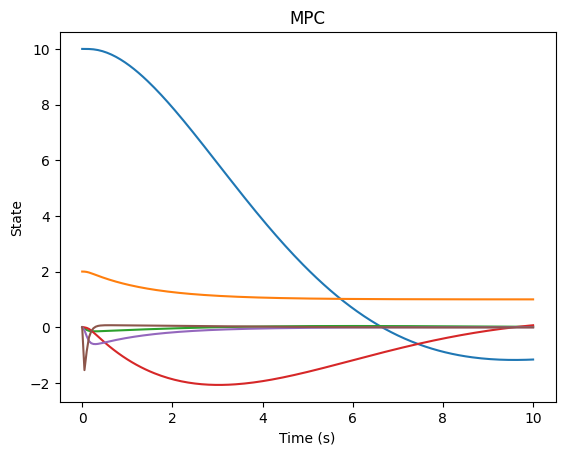

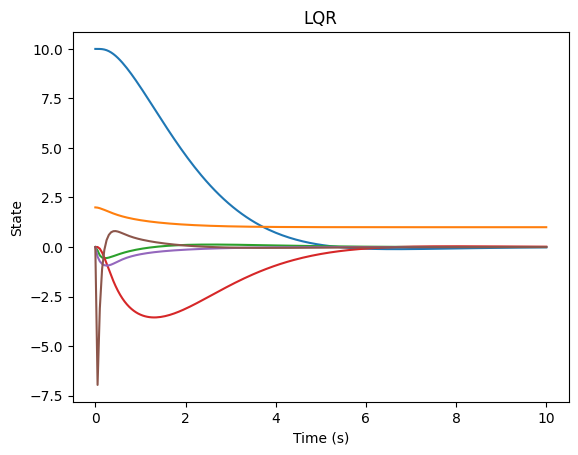

In [25]:
import matplotlib.pyplot as plt
times = np.arange(0, (Nt ) * h, h)
plt.plot(times, xhist2[:,:].T)
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.title("MPC")
plt.show()

plt.plot(times, xhist1.T)
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.title("LQR")
plt.show()



## Display in Mujoco for a nice visualization

In [26]:
from pathlib import Path
import mujoco
import mujoco.viewer
import time

model_name = f"scene"
model_path = Path("mujoco_models/skydio_x2") / (str(model_name) + str(".xml"))
    # Load the model and data
model = mujoco.MjModel.from_xml_path(str(model_path.absolute()))


data = mujoco.MjData(model)
data.qpos[1] = xhist2[0,0]
data.qpos[2] = xhist2[1,0]
data.qpos[4] = xhist2[2,0]
i = 0
start_time = time.time()
with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=False) as viewer:
    viewer.cam.azimuth = 140
    viewer.cam.elevation = -20
    viewer.cam.distance =  8
    viewer.cam.lookat = np.array([1.0 , -0.8 , 1.1])
    while viewer.is_running():
        if i < Nt:
            i+=1
        step_start = time.time()
        first_time = time.time()

        # mj_step can be replaced with code that also evaluates
        # a policy and applies a control signal before stepping the physics.
        # input("wait")
        mujoco.mj_step(model, data)
            
        data.qpos[1] = xhist2[0,i]
        data.qpos[2] = xhist2[1,i]
        data.qpos[4] = xhist2[2,i]
        viewer.sync()
        time_until_next_step = 0.05 - (time.time() - step_start)
        if time_until_next_step > 0:
            # print(time_until_next_step)
            time.sleep(time_until_next_step)
        # Pick up changes to the physics state, apply perturbations, update options from GUI.


2025-02-27 17:17:53.678 mjpython[51136:12644628] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-27 17:17:53.678 mjpython[51136:12644628] +[IMKInputSession subclass]: chose IMKInputSession_Modern
